In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as dt
import os
from os import path
import h5py
import re
from datetime import datetime
import requests

In [2]:
'''
Initialize variables
'''

#It can be left blank if the txt file is in the same path as the script
UNR_SITE_LIST_FILE = ''
folder_name = 'data'

lat = round(19.479,1)
lon = round(-155.602,1)

#Format yyyy-dd-MM
start_date = '2000-01-06'
end_date = '2021-01-07'

In [3]:
def date_to_decimal_year(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    year = date_obj.year
    day_of_year = date_obj.timetuple().tm_yday
    decimal_year = year + (day_of_year - 1) / 365.0
    decimal_year = round(decimal_year,2) 
    return decimal_year

In [4]:
def adapt_coordinates(lon, lat):

    if -179.95 <= lon <= 179.95:

        val = 0.5 if lon > 0 else  -0.5
        lon = lon*10 + val
        
    else:
        raise ValueError(f'Values not in the Interval (-179.5, 179.5)')
        
    if -89.95 <= lat <= 89.95:

        val = 0.5 if lat > 0 else -0.5
        lat = lat*10 + val

    else:
        raise ValueError(f'Values not in the Interval (-89.95, 89.95)')
        
    return lon, lat

In [5]:
def dload_site_list_hdf5(folder, path):
    '''
    Creates data folder
    '''
    if not folder:
        folder = 'data'
    
    if not os.path.exists(folder):
        os.mkdir(folder)

    '''
    Looks for list of links i.e. the only txt file in the current folder
    '''
    if not path:
    
        txt_files = [f for f in os.listdir('.') if f.endswith('.txt')]

        if len(txt_files) != 1:
            raise ValueError('should be only one txt file in the current directory')

        path = txt_files[0]

    '''
    Loop torough every line in the list of links .txt file and download every .HDF5 file within the list
    '''

    with open(path, "r") as ifile:
            for URL in ifile:
                if '.HDF5' in URL[-6:]:

                    d = re.search('\d{8}', URL)
                    d.group(0)
                    date = datetime.strptime(d.group(0), "%Y%d%m").date()

                    FILENAME = folder + '/'+ str(date) + '.HDF5'

                    if not os.path.exists(FILENAME):

                        result = requests.get(URL.strip())

                        try:
                            result.raise_for_status()
                            f = open(FILENAME,'wb')
                            f.write(result.content)
                            f.close()
                            print('contents of URL written to '+FILENAME)
                        except:
                            print('requests.get() returned an error code '+str(result.status_code))

                    else:
                        print(f'File: {FILENAME} already exists')
    return folder

In [6]:
def plot_precipitaion(longitude, latitude, start_date, end_date, folder, path):
        
        finaldf = {}
        df = pd.DataFrame()
        dictionary = {}
    
        longitude, latitude = adapt_coordinates(longitude, latitude)

        sdate = datetime.strptime(start_date,'%Y-%d-%m')
        edate = datetime.strptime(end_date,'%Y-%d-%m')
        
        #Create a date range with the input dates, from start_date to end_date
        date_list = pd.date_range(start = sdate,end = edate).date
        
        #If the folder name is left blank, it will be automatically named 'data'
        if not folder:
            folder = 'data'

        '''
        Check if files date is in range with the input dates
        '''   
        
        #Check if folder exists, otherwise execute download function
        if not os.path.exists(folder):
            folder = dload_site_list_hdf5(folder, path)
            
        else:
            
            try:
                
                #Converts file names within the data folder in date
                sd = datetime.strptime(os.listdir(folder)[0].replace('.HDF5',''),'%Y-%d-%m').date()
                ed = datetime.strptime(os.listdir(folder)[-1].replace('.HDF5',''),'%Y-%d-%m').date()

                #Create a range of dates with the name of the files within the data folder
                file_date_list = pd.date_range(start = sd,end = ed).date

                #Check if the date range passed as input is within the date range created from the downloaded files
                #if not, launch the download function
                if not all(elem in file_date_list for elem in date_list):

                    folder = dload_site_list_hdf5(folder, path)
            except:
                
                folder = dload_site_list_hdf5(folder, path)

        '''
        Loops trough every HDF5 file
        '''
        
        #For each file in the data folder that as HDF5 extension
        for f in os.listdir(folder):

            if f.endswith('.HDF5'):

                file = './' + folder + '/'+ f
                    
                data = h5py.File(file,'r')

                d = re.search('\d{4}[-]\d{2}[-]\d{2}', file)
                date = datetime.strptime(d.group(0), "%Y-%d-%m").date()

                if date in date_list:

                    dictionary[str(date)] = {}

                    lon = np.arange(-1799.5, 1800.5, 1)
                    lat = np.arange(-899.5,900.5,1)

                    for key in data.keys():        
                        pre = data[key]['precipitation']
                        lonPrec = dict(zip(lon, zip(*pre)))

                    lonPrec[longitude]

                    i = list(lat).index(latitude)
                    dictionary[str(date)] = lonPrec[longitude][0][i]

                    df1 = pd.DataFrame(dictionary.items(), columns=['Date', 'Precipitation'])
                    finaldf = pd.concat([df,df1], ignore_index=True, sort=False)

                else: continue
                    
        return finaldf  

In [ ]:
newdf = plot_precipitaion(lon, lat, start_date, end_date, folder_name, '') 

contents of URL written to data/2000-01-06.HDF5


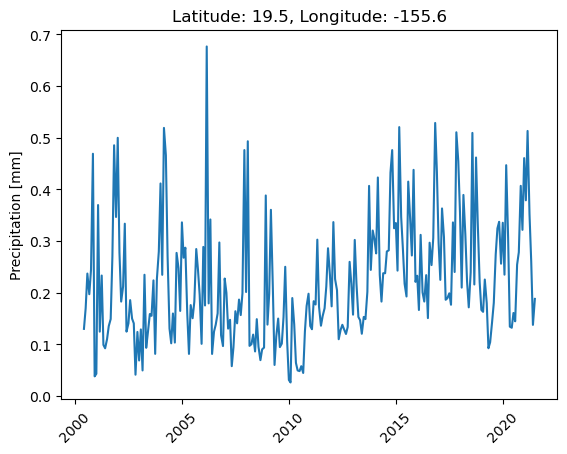

In [19]:
# newdf["roll30"] = newdf.Precipitation.rolling(30).sum()
# newdf["roll90"] = newdf.Precipitation.rolling(90).sum()
# newdf["roll180"] = newdf.Precipitation.rolling(180).sum()

# newdf["log30"] = np.log(newdf.roll30)
# newdf["log90"] = np.log(newdf.roll90)
# newdf["log180"] = np.log(newdf.roll180)
# newdf['norm']=(newdf.Precipitation-newdf.Precipitation.min())/(newdf.Precipitation.max()-newdf.Precipitation.min())

newdf["cum"] = newdf.Precipitation.cumsum()

rainfalldfNoNull =newdf.dropna()

# Convert date strings to decimal years
rainfalldfNoNull['Decimal_Year'] = rainfalldfNoNull['Date'].apply(date_to_decimal_year)

# plt.plot(newdf.Date,newdf.Precipitation)
plt.plot(rainfalldfNoNull.Decimal_Year, rainfalldfNoNull.Precipitation)

# plt.plot(rainfalldfNoNull.Date, rainfalldfNoNull.Precipitation)
# Calculate intervals base on Dataframe dimension
# interval = round((newdf.shape[0]/100)*20)
# Invervals for x axes label
# plt.gca().xaxis.set_major_locator(dt.DayLocator(interval=interval))

plt.xticks(rotation=45)

#Set y label
plt.ylabel("Precipitation [mm]")

#Set title
plt.title(f'Latitude: {lat}, Longitude: {lon}')

# Data plot
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

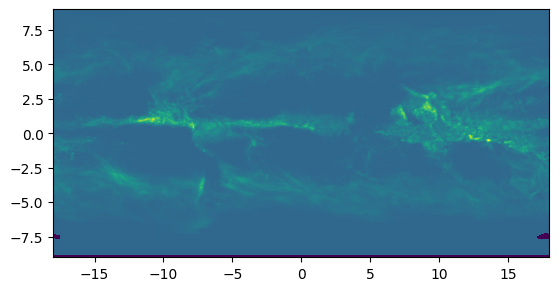

In [67]:
'''
Example of global precipitations given by Nasa at: https://gpm.nasa.gov/data/tutorials
'''

import os
from matplotlib import pyplot as plt
import h5py
import numpy as np

file = '/Users/giacomo/onedrive/scratch/gpm_data/2000-06-01.HDF5'

data = h5py.File(file,'r')
precip = data['/Grid/precipitation'][:]
precip = np.flip( precip[0,:,:].transpose(), axis=0 )
plt.imshow( precip, vmin=-1, vmax=2, extent=[-18,18,-9,9] )


# -- add a color bar
cbar = plt.colorbar( )
cbar.set_label('millimeters/hour')

# # -- display lat/lon grid lines
# for lon in np.arange(-90,90+1,90):
#   dummy = plt.plot( (lon,lon), (-90,+90), color="black", linewidth=1 )

# for lat in np.arange(-60,60+1,30):
#   dummy = plt.plot( (-180,+180), (lat,lat), color="black", linewidth=1 )

In [3]:
import sys
print(sys.executable)


/Library/Frameworks/Python.framework/Versions/3.11/bin/python3


-90.99999999999994 -62.214776299999926 -180.99999999999991 181.0


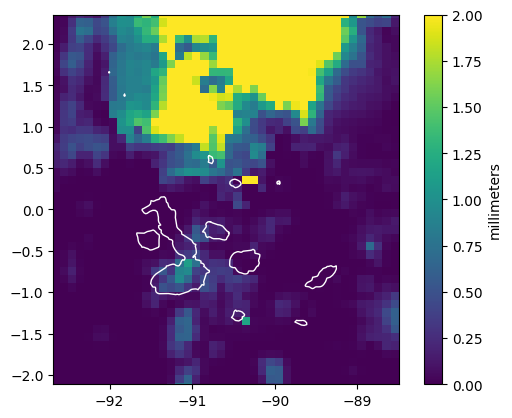

In [150]:
import netCDF4 as nc
import geopandas as gpd
from matplotlib.path import Path

file = '/Users/giacomo/onedrive/scratch/gpm_data/2000-06-01.nc4'

ds = nc.Dataset(file)

try:
    data = ds['precipitationCal']

except:
    data = ds['precipitation']

'''
Example of global precipitations given by Nasa at: https://gpm.nasa.gov/data/tutorials
'''

precip = data[:]
# Assuming data is your array
precip = np.array(data[:])

# Replace all negative values with 0
precip = precip.clip(min=0)

precip = np.flip( precip[0,:,:].transpose(), axis=0 )

xmin, xmax, ymin, ymax = -180, 180, -90, 90
extent = [xmin, xmax, ymin, ymax]


mapgalapagos = '/Users/giacomo/Desktop/worldheritagemarineprogramme/worldheritagemarineprogramme.shp'
mapEarth = '/Users/giacomo/Desktop/ne_10m_land/ne_10m_land.shp'

island_boundary = gpd.read_file(mapEarth)
geometry = island_boundary['geometry']

# Extract coordinates
coordinates = []
for geom in geometry:
    # Check the type of the geometry and extract coordinates accordingly
    if geom.geom_type == 'Polygon':
        # For polygons, extract exterior coordinates
        coords = geom.exterior.coords[:]
        coordinates.append(coords)
    elif geom.geom_type == 'MultiPolygon':
        # For multi-polygons, extract exterior coordinates for each polygon
        for polygon in geom.geoms:  # Use the 'geoms' attribute to iterate over polygons
            coords = polygon.exterior.coords[:]
            coordinates.append(coords)

# Print or use the extracted coordinates
coord = coordinates[0]

max_latitude = -90
max_longitude = -180
min_latitude = 90
min_longitude = 180

for c in coord:
    if c[0] > max_longitude:
        max_longitude = c[0]
        
    if c[0] < min_longitude:
        min_longitude = c[0]

    if c[1] > max_latitude:
        max_latitude = c[1]

    if c[1] < min_latitude:
        min_latitude = c[1]


# plt.imshow(precip[ymin:ymax, xmin:xmax], vmin=-1, vmax=2, extent=extent)
plt.imshow( precip, vmin=0, vmax=2, extent=[-180,180,-90,90] )
island_boundary.plot(ax=plt.gca(), edgecolor='white', facecolor='none') #plot shapefile

plt.ylim((-3.113)+1, (3.353)-1) #lat
plt.xlim((-93.680)+1,(-87.4981)-1) #long

print(min_latitude-1, max_latitude+1, min_longitude-1,max_longitude+1)

# -- add a color bar
cbar = plt.colorbar( )
cbar.set_label('millimeters')


# # -- display lat/lon grid lines
# for lon in np.arange(-90,90+1,90):
#     plt.plot( (lon,lon), (-90,+90), color="black", linewidth=1 )

# for lat in np.arange(-60,60+1,30):
#     plt.plot( (-180,+180), (lat,lat), color="black", linewidth=1 )

# -- display lat/lon grid lines
# for lon in np.arange(xmin,xmax+1,(xmax/2)):
#     plt.plot( (lon,lon), (xmin,+xmax), color="black", linewidth=1 )

# for lat in np.arange(ymin,ymax+1,ymax/2):
#     plt.plot( (ymin,ymax), (lat,lat), color="black", linewidth=1 )

In [148]:
file = '/Users/giacomo/onedrive/scratch/gpm_data/2000-06-01.nc4'

ds = nc.Dataset(file)

latitude = [(-3.113)+1, (3.353)-1] #lat
longitude = [(-93.680)+1, (-87.4981)-1] #long

try:
    data = ds['precipitationCal']

except:
    data = ds['precipitation']

'''
Example of global precipitations given by Nasa at: https://gpm.nasa.gov/data/tutorials
'''

precip = data[:][0]

for i in range(len(latitude)):
    
    la = int(float(latitude[i]) *  10) /  10.0

    if -89.95 <= la <= 89.95:

        val = 0.05 if la > 0 else -0.05
        latitude[i] = la + val

    else:
        raise ValueError(f'Values not in the Interval (-89.95, 89.95)')
        
for i in range(len(longitude)):
    lo = int(float(longitude[i]) *  10) /  10.0

    if -179.95 <= lon <= 179.95:

        val = 0.05 if lo > 0 else  -0.05
        longitude[i] = lo + val

    else:
        raise ValueError(f'Values not in the Interval (-179.5, 179.5)')

latitude, longitude = np.array(latitude), np.array(longitude)

zoomed_precip=[]
for i in range(longitude[0], longitude[1] + 0.01):
    
    for j in range(latitude[0], latitude[1]):
        
        print(precip[i][j])
        

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [169]:
lat = np.round(np.arange(-89.95, 90.05, 0.1), 2)
lat

array([-89.95, -89.85, -89.75, ...,  89.75,  89.85,  89.95])